In [1]:
# This a toy-example demonstrates the creation of a Bell state and then applying
# a classical loop to keep mixing the state of the qubit until
# the prepared qubit is in the |0> state.
# The program uses a toy layer to define the quantum operations.
import qstack

program = None

In [2]:
%%qstack
@instruction-set: toy

allocate q1:
  mix q1
  allocate q2:
    entangle q1 q2
  measure
measure


[Kernel(target=QubitId(value='q1'), instructions=(QuantumInstruction(name='mix', targets=[QubitId(value='q1')], parameters={}), Kernel(target=QubitId(value='q2'), instructions=(QuantumInstruction(name='entangle', targets=[QubitId(value='q1'), QubitId(value='q2')], parameters={}),), callback=None)), callback=None)]

In [3]:
# Set up a local quantum machine to execute the program.
# Each machine in qstack is created to target a specific stack or instruction set.
# This ensures that the machine can correctly interpret and execute the program's instructions.
from qstack.machine import local_machine_for, create_callbacks

machine = local_machine_for(program.instruction_set)


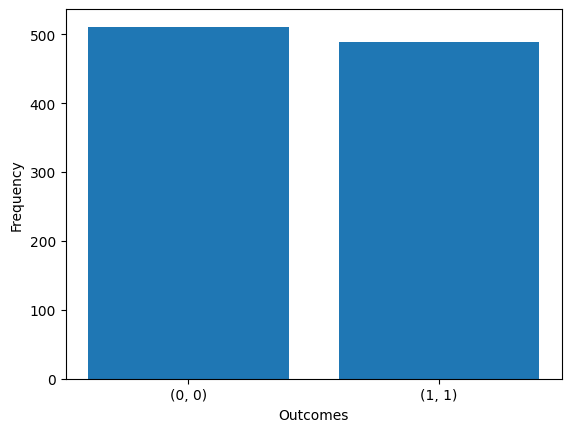

In [4]:
# Evaluate the program, it should give an even distribution betweek 
# (,0,0) and (1,1) when measuring the two qubits.

machine.eval(program).plot_histogram()


In [5]:
%%qstack
# Now incorporate a classical callback called repeat_until_zero...
# This callback will keep running the kernel until the outcome is "0".
# Since we're just consuming one outcome, the final result will be 0 followed by a list of 1s,
# a 1 for each time the loop was executed.
@instruction-set: toy

allocate q1:
  mix q1
  allocate q2:
    entangle q1 q2
  measure
measure
?? repeat_until_zero


[Kernel(target=QubitId(value='q1'), instructions=(QuantumInstruction(name='mix', targets=[QubitId(value='q1')], parameters={}), Kernel(target=QubitId(value='q2'), instructions=(QuantumInstruction(name='entangle', targets=[QubitId(value='q1'), QubitId(value='q2')], parameters={}),), callback=None)), callback=ClassicInstruction(name='repeat_until_zero', parameters={}))]

In [6]:
## The actual classical implementation of the callback:
from qstack.instruction_sets.toy import Mix, Entangle

# Define a classical callback for state preparation.
def repeat_until_zero(context):
    m = context.consume() 

    if m == 1:
        return qstack.Kernel.allocate("q1", "q2", 
                                instructions=[Mix("q1"), Entangle("q1", "q2")], 
                                callback=qstack.ClassicInstruction("repeat_until_zero", parameters={}))
    else:
        return None



In [7]:
# We need a new machine for this program that can
# invoke the classical callback

callbacks = create_callbacks(repeat_until_zero)
machine = local_machine_for(program.instruction_set, callbacks)


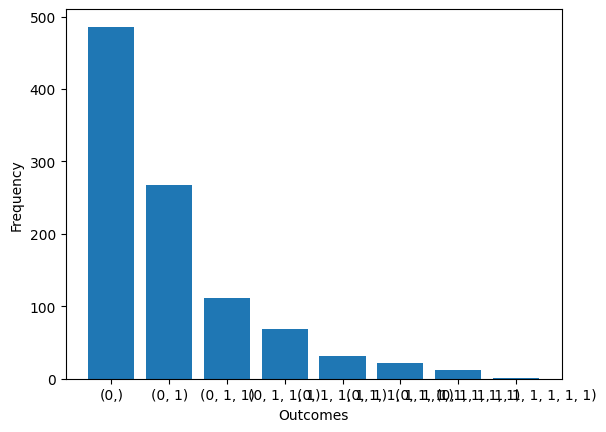

In [8]:
# The new histogram returns a distribution of bitstrings that start with 0
# followed by 1, the longer sequences appear much less, should be in exponential decay.

machine.eval(program).plot_histogram()


In [9]:
# Let's  turn on the logs
# and see the actual evaluation of the program.
# You'll notice that the number of calls to mix depends on the outcome as expected.
import logging

logger = logging.getLogger("qstack")

handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

In [12]:
machine.single_shot(program)

2025-05-28 23:25:30,143 - DEBUG - restart: 2
2025-05-28 23:25:30,146 - DEBUG - eval: mix [1]
2025-05-28 23:25:30,148 - DEBUG - eval: entangle [0, 1]
2025-05-28 23:25:30,150 - DEBUG - outcome: 0
2025-05-28 23:25:30,152 - DEBUG - outcome: 0


(0,)

In [13]:
machine.single_shot(program)

2025-05-28 23:25:35,840 - DEBUG - restart: 2
2025-05-28 23:25:35,844 - DEBUG - eval: mix [1]
2025-05-28 23:25:35,848 - DEBUG - eval: entangle [0, 1]
2025-05-28 23:25:35,850 - DEBUG - outcome: 1
2025-05-28 23:25:35,851 - DEBUG - outcome: 1
2025-05-28 23:25:35,854 - DEBUG - eval: mix [1]
2025-05-28 23:25:35,857 - DEBUG - eval: entangle [0, 1]
2025-05-28 23:25:35,859 - DEBUG - outcome: 1
2025-05-28 23:25:35,861 - DEBUG - outcome: 1
2025-05-28 23:25:35,863 - DEBUG - eval: mix [1]
2025-05-28 23:25:35,866 - DEBUG - eval: entangle [0, 1]
2025-05-28 23:25:35,867 - DEBUG - outcome: 1
2025-05-28 23:25:35,869 - DEBUG - outcome: 1
2025-05-28 23:25:35,870 - DEBUG - eval: mix [1]
2025-05-28 23:25:35,872 - DEBUG - eval: entangle [0, 1]
2025-05-28 23:25:35,873 - DEBUG - outcome: 1
2025-05-28 23:25:35,875 - DEBUG - outcome: 1
2025-05-28 23:25:35,876 - DEBUG - eval: mix [1]
2025-05-28 23:25:35,878 - DEBUG - eval: entangle [0, 1]
2025-05-28 23:25:35,879 - DEBUG - outcome: 1
2025-05-28 23:25:35,881 - DEBU

(0, 1, 1, 1, 1, 1, 1)

In [14]:
machine.single_shot(program)

2025-05-28 23:25:38,104 - DEBUG - restart: 2
2025-05-28 23:25:38,108 - DEBUG - eval: mix [1]
2025-05-28 23:25:38,110 - DEBUG - eval: entangle [0, 1]
2025-05-28 23:25:38,112 - DEBUG - outcome: 1
2025-05-28 23:25:38,114 - DEBUG - outcome: 1
2025-05-28 23:25:38,115 - DEBUG - eval: mix [1]
2025-05-28 23:25:38,116 - DEBUG - eval: entangle [0, 1]
2025-05-28 23:25:38,118 - DEBUG - outcome: 0
2025-05-28 23:25:38,119 - DEBUG - outcome: 0


(0, 1)

In [15]:
# Compile the toy program to the minimal Clifford instruction set.
# This step translates the toy instructions (like 'mix' and 'entangle')
# into a form that can be executed by a Clifford-based backend.
# Note: The classical callback (repeat_until_zero) may generate new kernels at runtime.
# When compiling, the compiler does not directly transform these dynamically generated kernels.
# Instead, it wraps the classical callback into a function that, when invoked, first evaluates
# the kernel and then just-in-time (JIT) compiles it before execution.
from qstack.compilers.toy2cliffords import ToyCompiler

compiler = ToyCompiler()
compiled, compiled_callbacks = compiler.compile(program, callbacks)

# Print the compiled program to see the transformed representation.
print(compiled)


2025-05-28 23:25:42,401 - WARNING - Instruction skew has no handler.


@instruction-set: cliffords-min

allocate q1:
  h q1
  allocate q2:
    cx q1 q2
  measure
measure
?? _toy2cliffords_:repeat_until_zero


In [19]:
# Evaluate the compiled program using the minimal Clifford instruction set.
# The logs will show that the quantum instructions evaluated are not those returned by the original callback,
# but the ones corresponding to those after compilation.
# The logs will not show that the kernel is compiled JIT, but you can observe the effect by the instructions executed.
machine = local_machine_for(compiled.instruction_set, compiled_callbacks)

machine.single_shot(compiled)

2025-05-28 23:25:49,719 - DEBUG - Found gate cz: [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]]
2025-05-28 23:25:49,722 - DEBUG - Found gate h: [[0.7071, 0.7071], [0.7071, -0.7071]]
2025-05-28 23:25:49,724 - DEBUG - Found gate cx: [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]
2025-05-28 23:25:49,726 - DEBUG - Found gate y: [[0, (-0-1j)], [1j, 0]]
2025-05-28 23:25:49,727 - DEBUG - Found gate z: [[1, 0], [0, -1]]
2025-05-28 23:25:49,729 - DEBUG - Found gate x: [[0, 1], [1, 0]]
2025-05-28 23:25:49,730 - DEBUG - restart: 2
2025-05-28 23:25:49,731 - DEBUG - eval: h [1]
2025-05-28 23:25:49,731 - DEBUG - eval: cx [0, 1]
2025-05-28 23:25:49,733 - DEBUG - outcome: 1
2025-05-28 23:25:49,733 - DEBUG - outcome: 1
2025-05-28 23:25:49,734 - DEBUG - eval: h [1]
2025-05-28 23:25:49,736 - DEBUG - eval: cx [0, 1]
2025-05-28 23:25:49,736 - DEBUG - outcome: 1
2025-05-28 23:25:49,740 - DEBUG - outcome: 1
2025-05-28 23:25:49,742 - DEBUG - eval: h [1]
2025-05-28 23:25:49,743 - DEBUG - e

(0, 1, 1, 1, 1)